![head.png](figures/head.jpg)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

In [9]:
# Packages used in this notebook
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# Working with satellite imagery

![head.png](figures/237845297_2005_ndwi_cof-0.39_p-0.00.png)

# Introduction to Google Earth Engine

Google Earth Engine (GEE) is a cloud-based platform for massive-scale analysis of geospatial data. It is commonly used for applications ranging from mapping and monitoring changes in the environment to managing natural resources.

Here is an [intro-to-python-api](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)

To interact with GEE, you need to authenticate and initialize the API. Make sure to install the `earthengine-api` Python package if you haven't done so.


In [10]:
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

## Retrieving data
First, let’s retrieve and display a high-resolution satellite image of a location in Germany, specifically around the coordinates (50.1271259, 8.6944529). We will also add a visual marker to highlight this area.

Available data sets: https://developers.google.com/earth-engine/datasets/

In [11]:
# Define the location and create a red box around it.
location = ee.Geometry.Point([11.973389898949094, 51.48454651201149])
rectangle = location.buffer(50).bounds()  # Buffer by 50m radius

# Load a high-resolution satellite image.
image_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(location) \
    .filterDate('2022-01-01', '2022-12-31') \
    .sort('CLOUD_COVERAGE_ASSESSMENT', True)  # Sort by cloud coverage for clearer images

# Take the first image from the collection (least cloudy)
image = image_collection.first()

# Display parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Visualize the image with a red box.
Map = geemap.Map(center=[51.48454651201149, 11.973389898949094], zoom=14)
Map.addLayer(image, vis_params, 'RGB')
Map.addLayer(rectangle, {'color': 'red'}, 'Rectangle')
#Map.centerObject(rectangle)
Map

Map(center=[51.48454651201149, 11.973389898949094], controls=(WidgetControl(options=['position', 'transparent_…

## Exploring spectral bands in satellite imagery

Satellite images are composed of various spectral bands, each capturing different parts of the electromagnetic spectrum. These bands can reveal different characteristics of the Earth's surface not visible to the naked eye. In this section, we'll explore how to visualize and interpret some of these spectral bands using high-resolution Sentinel-2 imagery.

We will focus on three key bands:
- **Blue band**: Useful for coastal and aerosol studies.
- **Green band**: Enhances the visibility of vegetation.
- **Red band**: Helps in identifying vegetation, soil, and urban areas.
- **NIR (Near-Infrared) band**: Essential for vegetation analysis.

HAve a look at the data set description: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED#bands

In [12]:
# Visualization parameters for different bands
vis_blue = {'bands': ['B2'], 'min': 0, 'max': 3000, 'gamma': 1.0}
vis_green = {'bands': ['B3'], 'min': 0, 'max': 3000, 'gamma': 1.0}
vis_red = {'bands': ['B4'], 'min': 0, 'max': 3000, 'gamma': 1.0}
vis_nir = {'bands': ['B8'], 'min': 0, 'max': 3000, 'gamma': 1.0}

# Create a map to display these bands
Map = geemap.Map(center=[51.48454651201149, 11.973389898949094], zoom=14)
Map.addLayer(image, vis_params, 'RGB')
Map.addLayer(image, vis_blue, "Blue Band")
Map.addLayer(image, vis_green, "Green Band")
Map.addLayer(image, vis_red, "Red Band")
Map.addLayer(image, vis_nir, "Near-Infrared Band")
Map.addLayer(rectangle, {'color': 'red'}, 'Rectangle')

# Add layer control and display map
Map.addLayerControl()
Map

Map(center=[51.48454651201149, 11.973389898949094], controls=(WidgetControl(options=['position', 'transparent_…

## Best available pixel (BAP) method

When working with satellite imagery, the quality of data is crucial. High cloud coverage, snow, and sensor errors can obscure the information. To address this, we can use a Best Available Pixel (BAP) approach that selects the best quality pixels from a stack of images.

![head.png](figures/s04_compositing.png)

Source: https://pages.cms.hu-berlin.de/EOL/gcg_eo/04_baps.html


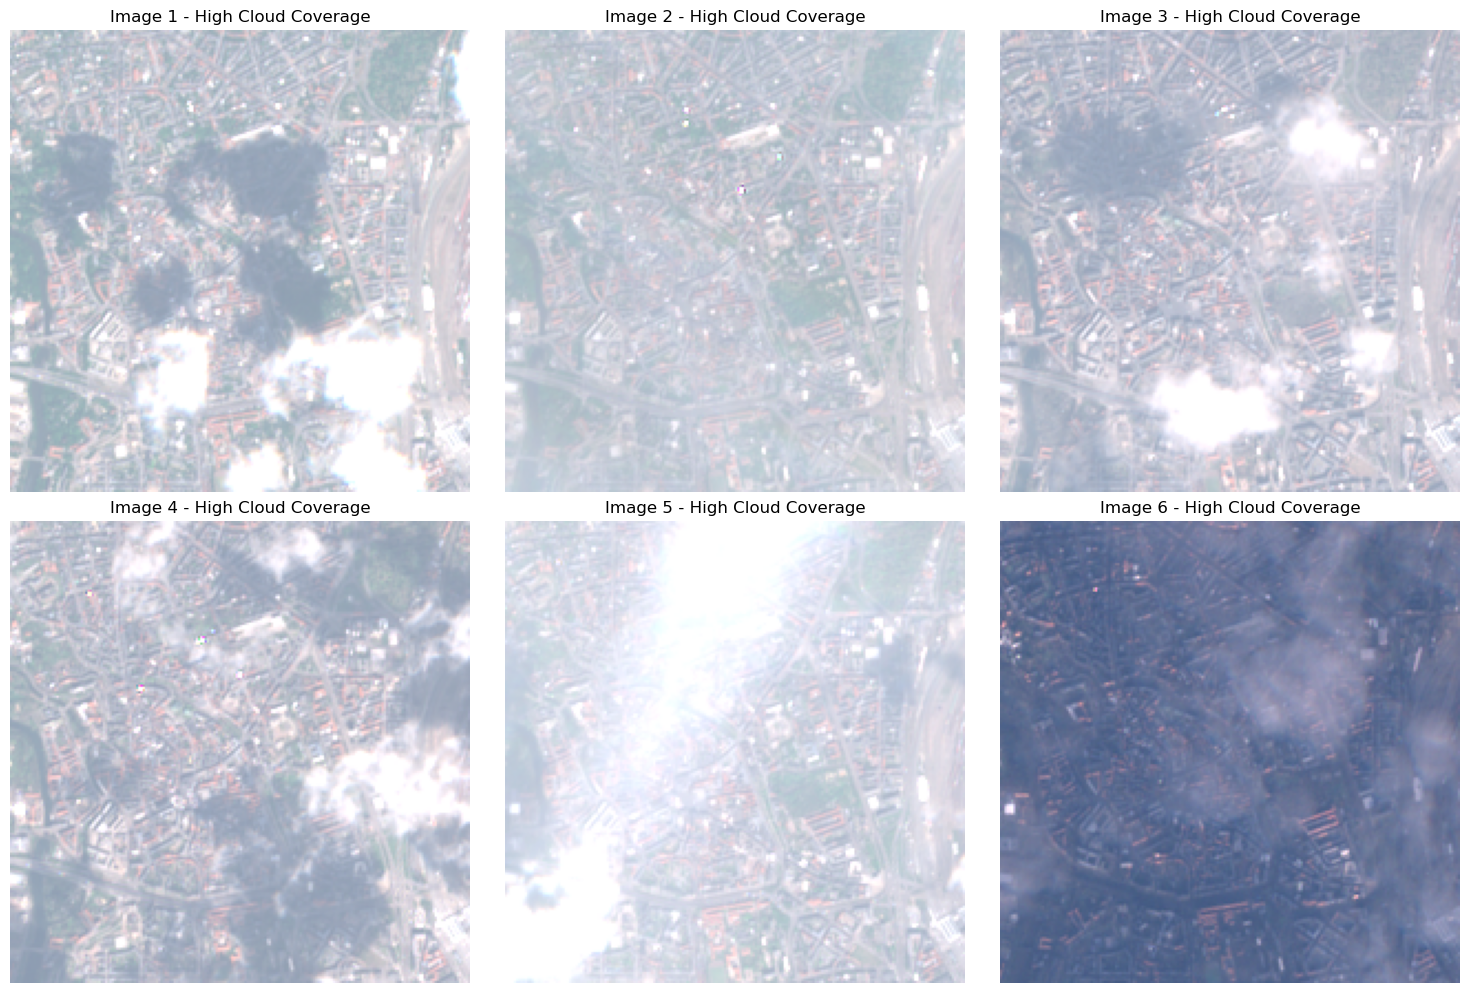

In [13]:
# Filter the image collection to include only those with a cloud coverage assessment of 50% or less
filtered_images = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(rectangle) \
    .filterDate('2022-01-01', '2022-12-31') \
    .filter(ee.Filter.lte('CLOUD_COVERAGE_ASSESSMENT', 25))  # Limit to max 25% cloud coverage

# Retrieve the 6 images with the worst cloud coverage
worst_images = filtered_images.sort('CLOUD_COVERAGE_ASSESSMENT', False).limit(6)

# Create a figure with 3x2 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loop through each image and plot it
for idx, ax in enumerate(axs.flatten()):
    image = ee.Image(worst_images.toList(worst_images.size()).get(idx))
    # Using geemap to convert Earth Engine image to numpy array
    rgb_img = geemap.ee_to_numpy(image.visualize(**vis_params), 
                                 region=location.buffer(1000).bounds()
                                 )
    ax.imshow(np.clip(rgb_img / 255.0, 0, 1))
    ax.set_title(f"Image {idx + 1} - High Cloud Coverage")
    ax.axis('off')

# Display the figure
plt.tight_layout()
plt.show()

### Best available pixel (BAP) composite using `qualityMosaic`

The `qualityMosaic` method in Google Earth Engine is a technique for creating a composite image from a collection of images. This method selects the pixel with the best quality according to a specified quality band across all images in the collection. In our example, we use the 'QA60' band from Sentinel-2, which provides cloud probability and cloud shadow information for each pixel.

By applying `qualityMosaic`, we create a composite image that combines the best pixels (least cloud cover and shadows) from multiple images, ensuring that each pixel in the output composite represents the clearest available observation from the image collection. This approach is particularly useful in scenarios where cloud cover significantly impacts the usability of satellite imagery.

The resulting map visualizes this composite, with a red box around our area of interest, illustrating a clearer view of the landscape compared to individual cloudy images.

Have a look at: https://philippgaertner.github.io/2020/08/percent-cloud-cover/

In [14]:
# Create a composite image from filtered_images
pixel_composite = filtered_images.qualityMosaic('QA60')

# Display the composite
Map = geemap.Map(center=[51.48454651201149, 11.973389898949094], zoom=14)
Map.addLayer(pixel_composite, vis_params, "BAP Composite")
Map.addLayer(rectangle, {'color': 'red'}, 'Location Box')
Map

Map(center=[51.48454651201149, 11.973389898949094], controls=(WidgetControl(options=['position', 'transparent_…

### Best available pixel (BAP) composite using `median` reducer

Another approach to generate a Best Available Pixel (BAP) composite is by using a `median` reducer. This method computes the median value for each pixel across all images in the collection. The median is less sensitive to outliers such as clouds and shadows, which can significantly distort the values in an image.

By applying the `median` reducer, we filter out these outliers and achieve a more representative depiction of the underlying true values at each location. This method is especially effective when dealing with a larger set of images where variations due to atmospheric conditions, angle of sunlight, and other temporal factors may affect individual observations.

The map created using this method also includes the red box around our area of interest, showcasing a consistent and reliable representation of the landscape, normalized across the selected time period.



In [15]:
median_composit = filtered_images.median()

# Display the composite
Map = geemap.Map(center=[51.48454651201149, 11.973389898949094], zoom=14)
Map.addLayer(median_composit, vis_params, "BAP Composite")
Map.addLayer(rectangle, {'color': 'red'}, 'Location Box')
Map

Map(center=[51.48454651201149, 11.973389898949094], controls=(WidgetControl(options=['position', 'transparent_…

## Extracting indices from satellite imagery

Indices derived from satellite imagery can provide insightful metrics about various earth surface conditions. One of the most widely used indices is the Normalized Difference Vegetation Index (NDVI), which measures the health and density of vegetation based on the difference in reflectance between the near-infrared (NIR) and red light. NDVI values range from -1 to +1, where higher values indicate healthier vegetation.

In this section, we will calculate the NDVI for our area of interest over a selected time period and plot the NDVI values as a time series to observe changes in vegetation health over time.


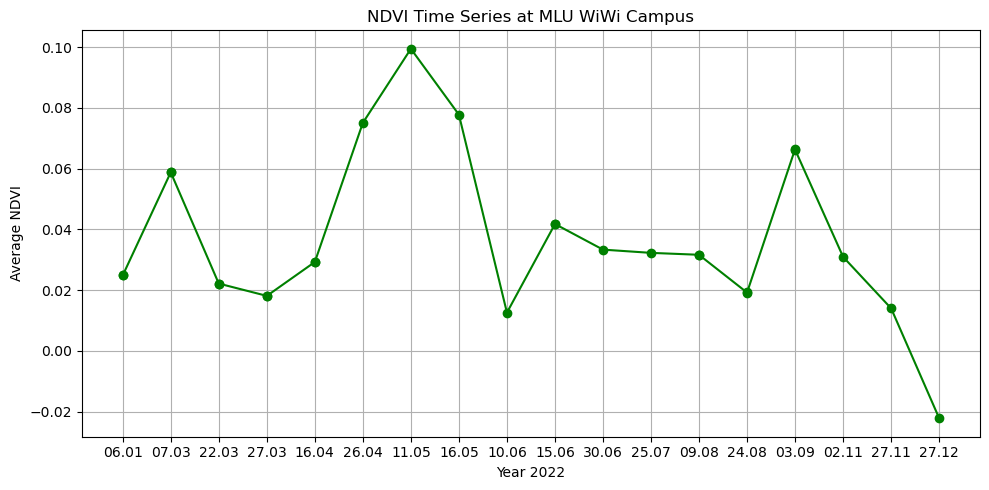

In [16]:
# Define a function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # B8 is NIR and B4 is Red
    return image.addBands(ndvi)

# Map the function over the image collection
ndvi_collection = filtered_images.map(calculate_ndvi)

# Select the NDVI band
ndvi_time_series = ndvi_collection.select('NDVI')

# Calculate average NDVI for each image over the region of interest
def mean_ndvi(image):
    mean = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=rectangle, scale=10).get('NDVI')
    return ee.Feature(None, {'mean_ndvi': mean, 'system:time_start': image.get('system:time_start')})

# Map the function over the NDVI collection
mean_ndvi_series = ndvi_time_series.map(mean_ndvi)

# Convert the collection to a list of features
ndvi_list = mean_ndvi_series.reduceColumns(ee.Reducer.toList(2), ['mean_ndvi', 'system:time_start']).get('list')

# Extract data for plotting
ndvi_data = ee.List(ndvi_list).getInfo()  # Getting data to client-side for plotting
ndvi_data = sorted(ndvi_data, key=lambda x: x[1])

# Extracting NDVI values and dates
dates = [ee.Date(x[1]).format('dd.MM').getInfo() for x in ndvi_data]
ndvi_values = [x[0] for x in ndvi_data]

# Plotting the NDVI time series using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(dates, ndvi_values, marker='o', linestyle='-', color='green')
plt.title('NDVI Time Series at MLU WiWi Campus')
plt.xlabel('Year 2022')
plt.ylabel('Average NDVI')
#plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()